[[4, 1, 0], [0, 6, 0], [0, 0, 0]]
[[5, 1, 0], [1, 4, 0], [0, 0, 0]]
[[5, 2, 0], [1, 3, 0], [0, 0, 0]]
[[3, 3, 0], [0, 5, 0], [0, 0, 0]]
[[2, 2, 0], [0, 7, 0], [0, 0, 0]]
[[1, 3, 0], [1, 6, 0], [0, 0, 0]]
[[2, 3, 0], [1, 5, 0], [0, 0, 0]]
[[3, 3, 0], [0, 5, 0], [0, 0, 0]]
[[4, 3, 0], [0, 4, 0], [0, 0, 0]]
[[3, 2, 0], [1, 5, 0], [0, 0, 0]]
Scores: [90.9090909090909, 81.81818181818183, 72.72727272727273, 72.72727272727273, 81.81818181818183, 63.63636363636363, 63.63636363636363, 72.72727272727273, 72.72727272727273, 72.72727272727273]
Mean Accuracy: 74.545%
[[3.2, 2.3], [0.5, 5.0]]


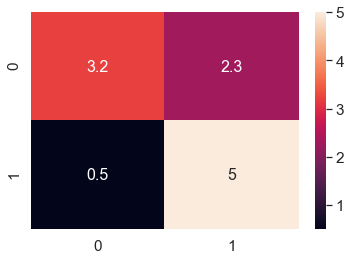

In [18]:
# Naive Bayes On The SPECTF Dataset
from csv import reader
from random import seed
from random import randrange
from math import sqrt
from math import exp
from math import pi
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset[1:]

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column])

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for _ in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted,m):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
# 			print(actual[i],predicted[i])
			correct += 1
		m[actual[i]][predicted[i]]=m[actual[i]][predicted[i]]+1
	return correct / float(len(actual)) * 100.0,m

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	mat=[[0 for x in range(2)]for x in range(2)]
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		m=[[0 for x in range(3)]for x in range(3)]
		accuracy,m = accuracy_metric(actual, predicted,m)
		for x in range(2):
			for y in range(2):
				mat[x][y]=mat[x][y]+m[x][y]
		scores.append(accuracy)
	for x in range(2):
		for y in range(2):
			mat[x][y]=mat[x][y]/10.0
	return scores,mat

# Split the dataset by class values, returns a dictionary
def separate_by_class(dataset):
	separated = dict()
	for i in range(len(dataset)):
		vector = dataset[i]
		class_value = vector[-1]
		if (class_value not in separated):
			separated[class_value] = list()
		separated[class_value].append(vector)
	return separated

# Calculate the mean of a list of numbers
def mean(numbers):
	return sum(numbers)/float(len(numbers))

# Calculate the standard deviation of a list of numbers
def stdev(numbers):
	avg = mean(numbers)
	variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
	return sqrt(variance)

# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(dataset):
	summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
	del(summaries[-1])
	return summaries

# Split dataset by class then calculate statistics for each row
def summarize_by_class(dataset):
	separated = separate_by_class(dataset)
	summaries = dict()
	for class_value, rows in separated.items():
		summaries[class_value] = summarize_dataset(rows)
	return summaries

# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
	exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
	return (1 / (sqrt(2 * pi) * stdev)) * exponent

# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
	total_rows = sum([summaries[label][0][2] for label in summaries])
	probabilities = dict()
	for class_value, class_summaries in summaries.items():
		probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
		for i in range(len(class_summaries)):
			mean, stdev, _ = class_summaries[i]
			probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
	return probabilities

# Predict the class for a given row
def predict(summaries, row):
	probabilities = calculate_class_probabilities(summaries, row)
	best_label, best_prob = None, -1
	for class_value, probability in probabilities.items():
		if best_label is None or probability > best_prob:
			best_prob = probability
			best_label = class_value
	return best_label

# Naive Bayes Algorithm
def naive_bayes(train, test):
	summarize = summarize_by_class(train)
	predictions = list()
	for row in test:
		output = predict(summarize, row)
		predictions.append(output)
	return(predictions)

# Test Naive Bayes on Iris Dataset
seed(1)
filename = 'Datasets/SPECT.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# evaluate algorithm
n_folds = 5
scores,mat = evaluate_algorithm(dataset, naive_bayes, 10)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))
print(mat)
df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()